In [5]:
from matplotlib import pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc, accuracy_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.multioutput import MultiOutputClassifier
from itertools import cycle
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay

In [6]:
dataset = pd.read_csv("/kaggle/input/combined-dataset-before-smote/output-2.csv", header = None, delimiter = ',')
print(dataset)

        0    1    2   3   4    5    6   7   8   9   ...  20  21   22  23  24  \
0       83   77    7  21  11   11   41  19   9  83  ...   7  34   24  12  38   
1       11    3  106  42   5    8  110   9  92   1  ...  10   9  125  52  11   
2       18   50   20  15  18   12   17  46  40  26  ...  12   2   26  47   3   
3        4   21  100   9  61    7   18  74  50  23  ...  75  18   67  22   8   
4       10  103   97  62  40   49   20  90  22  11  ...  28  40   86  78  19   
...     ..  ...  ...  ..  ..  ...  ...  ..  ..  ..  ...  ..  ..  ...  ..  ..   
147108  96   77   36  69   6    6   77  70  45  88  ...   9  34   24  31  22   
147109  10    2    5  51  10   62   20  55  83  12  ...  10  19   85  80  53   
147110  31   51    5   1  74  105   51  65  20  49  ...  25  59   86  17  60   
147111   9    1   28   2  20   12   14  74  50  23  ...  74  39   36  22  18   
147112  16   17    2   2  60    7   14  74  50  16  ...  74   5   44  14   5   

        25  26  27  28  29  
0       37

In [7]:
X = dataset.drop(columns = [26,27,28,29])
y = dataset.filter([26,27,28,29])
print("X of the dataset: \n",X)
print("y of the dataset: \n", y)

X of the dataset: 
         0    1    2   3   4    5    6   7   8   9   ...   16  17   18   19  \
0       83   77    7  21  11   11   41  19   9  83  ...   21  12   11   41   
1       11    3  106  42   5    8  110   9  92   1  ...   19  27    8  110   
2       18   50   20  15  18   12   17  46  40  26  ...  130  55   12   17   
3        4   21  100   9  61    7   18  74  50  23  ...   10  61   16   56   
4       10  103   97  62  40   49   20  90  22  11  ...   33  38   49   20   
...     ..  ...  ...  ..  ..  ...  ...  ..  ..  ..  ...  ...  ..  ...  ...   
147108  96   77   36  69   6    6   77  70  45  88  ...   24  11   22   23   
147109  10    2    5  51  10   62   20  55  83  12  ...   33  29   62   20   
147110  31   51    5   1  74  105   51  65  20  49  ...   26  46  105  100   
147111   9    1   28   2  20   12   14  74  50  23  ...    2  20   41   14   
147112  16   17    2   2  60    7   14  74  50  16  ...    2  60   47   14   

        20  21   22  23  24  25  
0        

In [8]:
#max_score = 0
#best_estimator = 50
#best_learning_rate = 1.0
#n_estimator_list = [50,100,150,200]
#learning_rate_list = [1.0,2.0,3.0]

#for e in n_estimator_list:
    #for l in learning_rate_list:
abc = AdaBoostClassifier(n_estimators = 200,learning_rate = 1.0)
classifier = MultiOutputClassifier(abc)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(classifier, X, y, cv=kfold)
score_mean = score.mean()
f1_scorer = make_scorer(f1_score, average='micro')
f1_score_value = cross_val_score(classifier, X, y, cv=kfold, scoring= f1_scorer)
    #if score_mean > max_score:
            #best_scores = score
            #max_score = score_mean
            #best_estimator = e
            #best_learning_rate = l

In [9]:
print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.8f}".format(score_mean))
print("Standard Deviation of scores: {:.8f}".format(score.std()))
#print("Best n_estimator and learning rate: ", best_estimator, best_learning_rate)

Cross-validation scores: [0.28175237 0.28127655 0.27243993 0.28186391 0.28227177]
Average cross-validation score: 0.27992091
Standard Deviation of scores: 0.00375390


In [10]:
f1_score_final = f1_score_value.mean()
print("Average F1 score:", f1_score_final)

Average F1 score: 0.6904608809409821


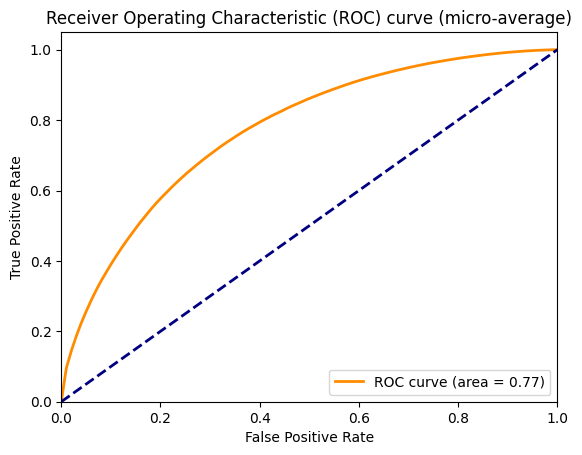

In [11]:
#After you train model, these blocks of code make tpr, fpr, precision and recall from it
#I hypertuned it separately to get the best parameters, and once I had the best ones, I used them directly as is
# Initialize variables to store fpr and tpr
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
mean_roc_auc = 0.0

# Iterate over folds
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit classifier and predict probabilities
    classifier.fit(X_train, y_train)
    probs = classifier.predict_proba(X_test)
    
    # Compute ROC curve for each class
    for i in range(y.shape[1]):
        fpr, tpr, _ = roc_curve(y_test.iloc[:, i], probs[i][:, 1])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        mean_roc_auc += auc(fpr, tpr)

# Normalize mean_tpr and mean_auc
mean_tpr /= kfold.n_splits * y.shape[1]
mean_roc_auc /= kfold.n_splits * y.shape[1]

# Plot micro-average ROC curve
plt.figure()
plt.plot(all_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % mean_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve (micro-average)')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/abc_5CV_roc_real_smote.png')
plt.show()

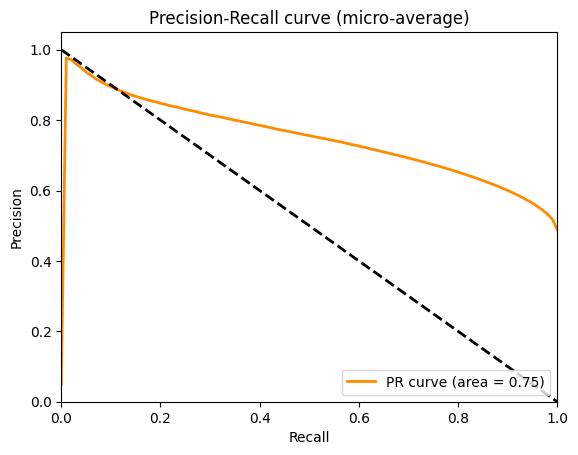

In [12]:
all_recall = np.linspace(0, 1, 100)
mean_precision = 0.0
mean_prc_auc = 0.0

# Iterate over folds
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit classifier and predict probabilities
    classifier.fit(X_train, y_train)
    probs = classifier.predict_proba(X_test)
    
    # Compute precision-recall curve for each class
    for i in range(y.shape[1]):
        precision, recall, _ = precision_recall_curve(y_test.iloc[:, i], probs[i][:, 1])
        mean_precision += np.interp(all_recall, recall[::-1], precision[::-1])
        mean_precision[0] = 1.0
        mean_prc_auc += auc(recall, precision)

# Normalize mean_precision and mean_auc
mean_precision /= kfold.n_splits * y.shape[1]
mean_prc_auc /= kfold.n_splits * y.shape[1]
# Plot micro-average precision-recall curve
plt.figure()
plt.plot(all_recall, mean_precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % mean_prc_auc)
plt.plot([0,1],[1,0], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (micro-average)')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/abc_5CV_prc_real_smote.png')
plt.show()

In [13]:
print(all_fpr)
print(mean_tpr)
print(all_recall)
print(mean_precision)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

In [14]:
output_file_path = '/kaggle/working/adaboost_real_smote_scores.txt'
with open(output_file_path, 'w') as f: 
    f.write("F1 Score: {}\n".format(f1_score_final))
    f.write("Precision: {}\n".format(mean_precision)) 
    f.write("Recall: {}\n".format(all_recall)) 
    f.write("PRC AUC: {}\n".format(mean_prc_auc)) 
    f.write("ROC AUC: {}\n".format(mean_roc_auc)) 
    f.write("TPR: {}\n".format(mean_tpr)) 
    f.write("FPR: {}\n".format(all_fpr))

In [15]:


import json

# Assuming tpr and fpr are NumPy arrays
print("Type of f1:", type(f1_score_final))
print("Type of precision:", type(precision))
print("Type of recall:", type(recall))
print("Type of tpr_value:", type(mean_tpr))
print("Type of fpr_value:", type(fpr))
print("Type of roc_auc:", type(mean_roc_auc))
print("Type of prc_auc:", type(mean_prc_auc))
print("Type of tpr:", type(tpr))
print("Type of fpr:", type(fpr))

precision_list = precision.tolist()
recall_list = recall.tolist()
tpr_list = tpr.tolist()
fpr_list = fpr.tolist()

#print(f1.type())

data = {
    "Average F1 Score": float(f1_score_final), 
    #"Average Precision": float(mean_precision), 
    #"Average Recall": float(recall_final), 
    #"Average True Positive Rate": float(tpr_final), 
    #"Average False Positive Rate": float(fpr_final), 
    "Average ROC AUC": mean_roc_auc, 
    "Average PRC AUC": mean_prc_auc,
    "TPR Array" : tpr_list,
    "FPR Array" : fpr_list,
    "Precision Array": precision_list, 
    "Recall Array": recall_list
}

# Specify the file path
file_path = "/kaggle/working/Adaboost - Synthetic - Lenny.json"

# Write the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

Type of f1: <class 'numpy.float64'>
Type of precision: <class 'numpy.ndarray'>
Type of recall: <class 'numpy.ndarray'>
Type of tpr_value: <class 'numpy.ndarray'>
Type of fpr_value: <class 'numpy.ndarray'>
Type of roc_auc: <class 'numpy.float64'>
Type of prc_auc: <class 'numpy.float64'>
Type of tpr: <class 'numpy.ndarray'>
Type of fpr: <class 'numpy.ndarray'>
